# Same idea as license plate recognition, but cleaned up some

The old one got REALLy messy since I named everything basically the same. also since its basically the same thing over and over, figured I coul d probably just make it into a function so its less gross

### Notes ###

* for first thresholding, best value seems to be 3 (t_mod). it is darker but helps with separating additional plates
    * best to err on the side of a little dark, then let avg_mod space_thresh separate properly
* for second and third thresholding (horizontal then second vertical cuts, respectively) -- assuming that a bit lighter is better. check this
* the avg_mod for space_thresh doesn't seem to make a difference until the image is darker, at which point a higher mod is good. 3 seems to be a sweet spot 

0


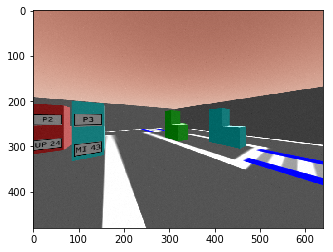

1


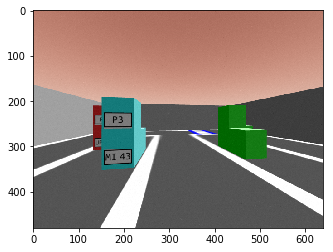

2


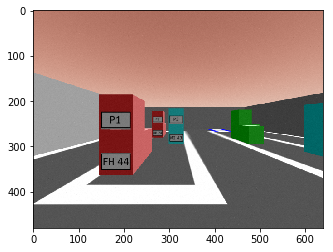

3


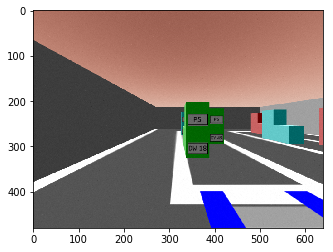

4


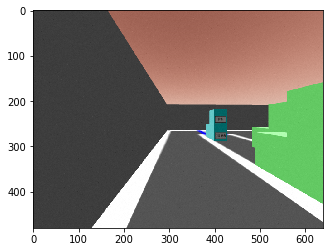

5


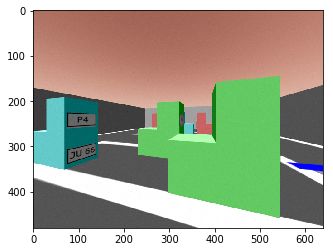

6


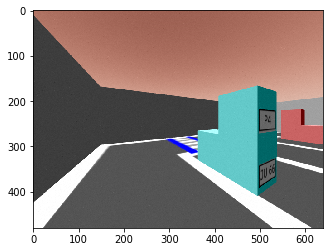

7


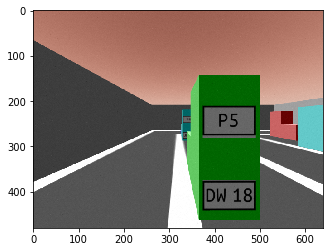

8


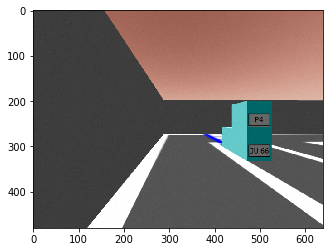

9


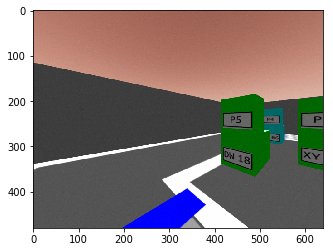

10


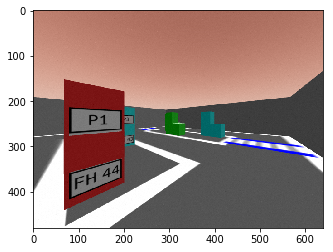

11


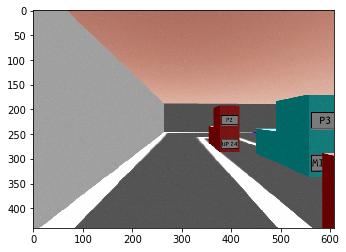

12


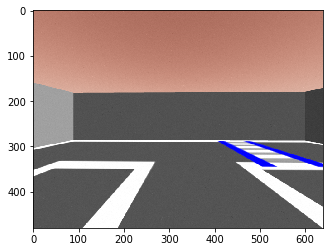

13


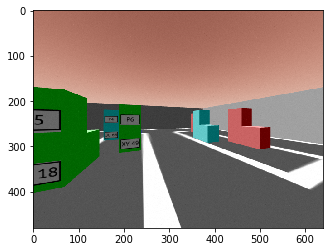

14


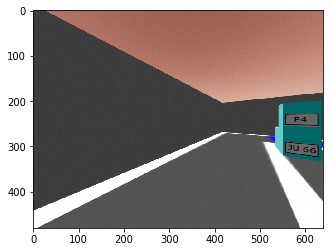

15


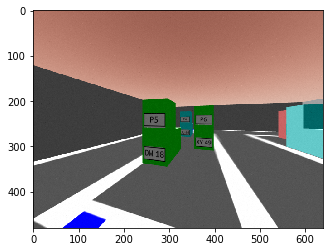

16


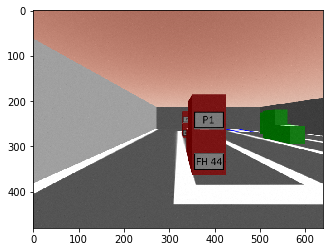

17


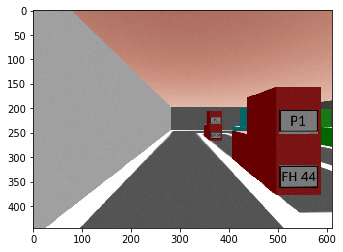

18


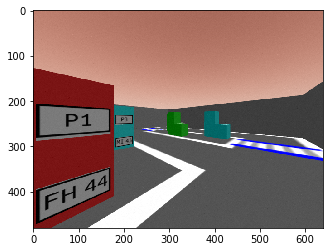

19


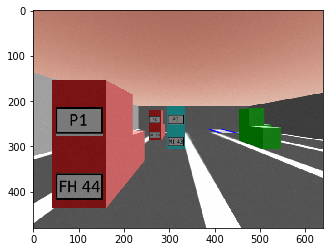

20


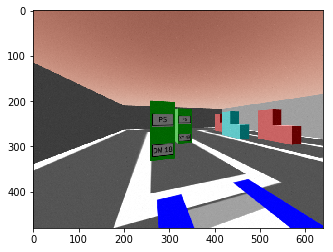

In [61]:
# get image from robot.

import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import statistics as sts

# get path to this directory
path = os.getcwd() + "/test_imgs/"  # gets current working directory. is "hacky" (replace this with os.path or smth on vs)

img_names = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
test_img_list = []
count = 0
for n in img_names:
    print(count)
    count += 1
    img = cv2.imread(path + n)
    test_img_list.append(img)
    plt.imshow(img)
    plt.show()

# TODO change this to get many license plates

### segment image THIS IS UPDATED NOW UPDATE IT PLS PLS
1. Convert to greyscale, then threshold to get clearer letters

2. Process to make sure there arent any false positives 
   * blur
   * ?? hopefully it will be good after the blur
    
3. Get vertical total (or average or whatever) pixel val
    * if it is under a certain threshold, theres no letter there
    
4. Chop up image

## Function to segment stuff
This gets the average pixel value along either vertical or horizonal lines in the image, then decides where the letters are based on when the value changes

In [115]:
''' 
image_list = a list of images to split. these should be greyscale

t_mod = to modify the threshold value for greyscaling image. 
            defaults to 3 (best val for first split). 
            probably needs to be changed for other splits
            
horizontal = True if splitting the image horizontally. default True

avg_mod = to pull the space-threshold value towards the average pixel value. 
            defaults to 3 based on testing done (most robust)
            
min_len = the minimum allowed length of chunk (pixels)
    
    
returns: chunks = a list of lists of indices to split the image with, with:
    len(chunks) = len(image_list)
    chunks[*] = list of pairs corresponding to image[*]
'''


def split_images(image_list, horizontal=True, avg_mod=3, t_mod=3.3, min_len=5):

    chunks = []
    count = 0
    
    for img_g in image_list:
        ''' threshold the image based on average pixel val, then blur '''
        grey_thresh = np.mean(img_g)/t_mod
        _, img_b = cv2.threshold(img_g, grey_thresh, 255, cv2.THRESH_BINARY)
        
        h, w = img_b.shape
        b = 5
        if w < 100:
            b = 2
            
        img = cv2.blur(img_b, (b,b))
        
        # print(count)
        # count += 1
        plt.imshow(img)
        plt.show()
        
        ''' get average pix val for each row '''
        pix_vals = []
        
        if horizontal:
            for i in range(h):
                pix_sum = 0
                for j in range(w):
                    pix_sum += img[i,j]
                pix_vals.append(pix_sum/w)
            # plt.plot(pix_vals, range(h))
            # plt.show()
            
        else:
            for i in range(w):
                pix_sum = 0
                for j in range(h):
                    pix_sum += img[j,i]
                pix_vals.append(pix_sum/h)
            # plt.plot(range(w), pix_vals)
            # plt.show()
      

        ''' 
        find where the average vals dip below a certain
        threshold, and count until they rise above that 
        threshold 
        '''
        avg_val = sts.mean(pix_vals)
        # print("average val: {}".format(avg_val))

        pix_vals_temp = pix_vals
        for i in range(50):
            try:
                # print("OOOOOOOOOO")
                mode_val = sts.mode(pix_vals_temp)
                # print("mode: {}".format(mode_val))
                break
            except sts.StatisticsError:
                print("Multiple modes")
                # increase every other thing by one
                for j in range(len(pix_vals_temp)):
                    if j % (i+1) == 0:
                        pix_vals_temp[j] += 1
        
        space_thresh = mode_val - abs(mode_val-avg_val)*(255-avg_val)*avg_mod/255
        # print("space thresh: {}".format(space_thresh))
        
        temp = []
        i = 0
        keep_going = False
        while i in range(len(pix_vals)):
            if(pix_vals[i] < space_thresh):

                if not keep_going:  # this is for if the previous chunk was determined too small
                    start = i

                while(pix_vals[i] < space_thresh):
                    i += 1
                    if i not in range(len(pix_vals)):
                        break
                        
                ''' 
                check if the chunk is very small. if it is, then
                keep the starting position and keep going 
                '''      
                if(abs(start-i) > min_len):  # maybe change this 2 --> 10 or smth
                    temp.append([start, i])
                    keep_going = False
                else:
                    keep_going = True

            i += 1

        if len(temp) < 1:
            temp = [] # this might already be the case but i just want to be sure lol
        
        chunks.append(temp)
    
    return chunks

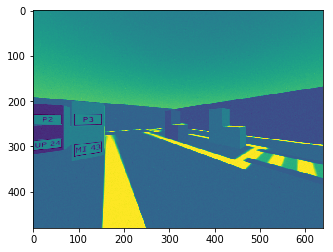

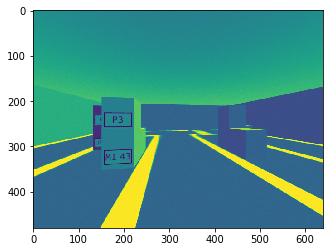

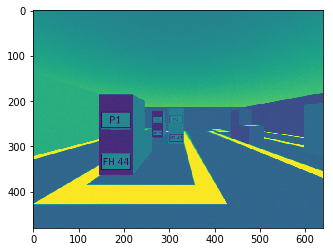

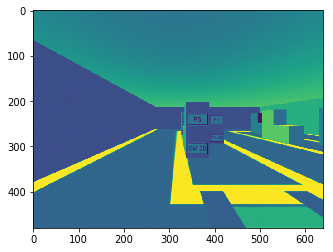

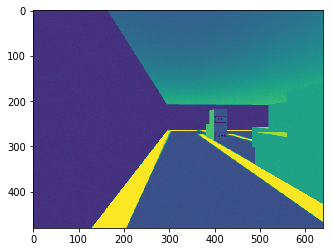

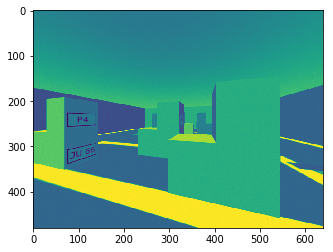

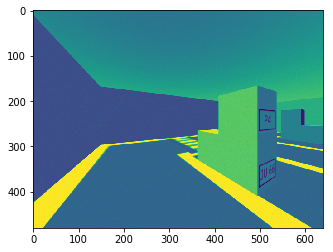

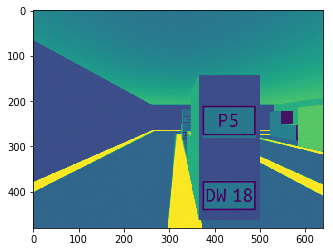

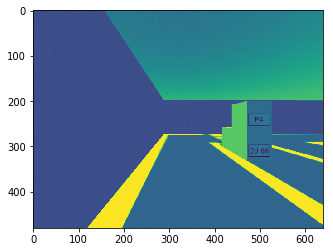

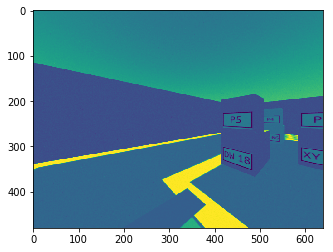

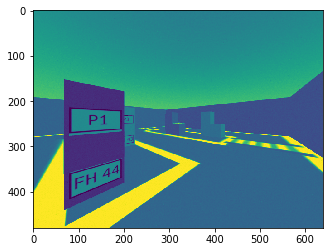

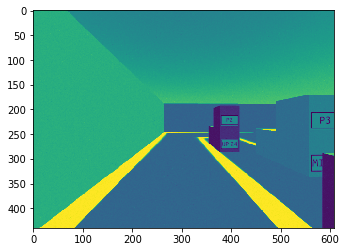

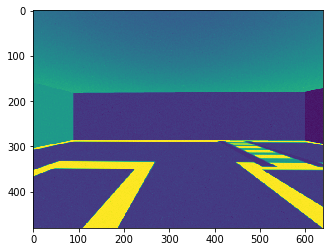

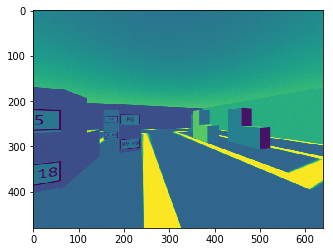

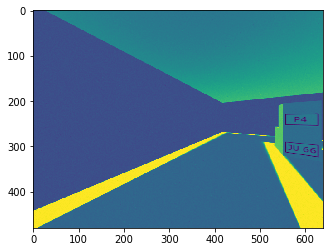

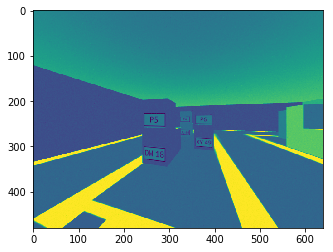

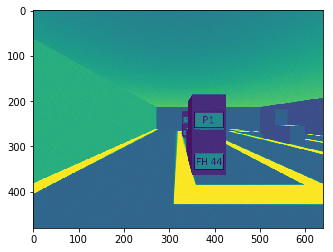

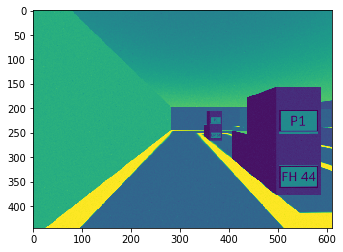

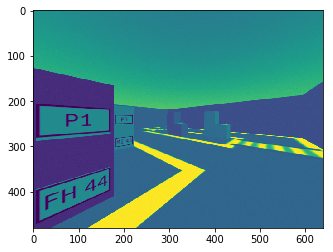

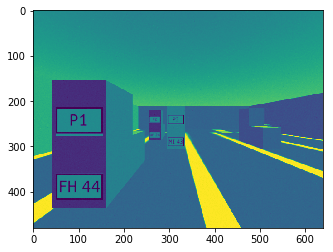

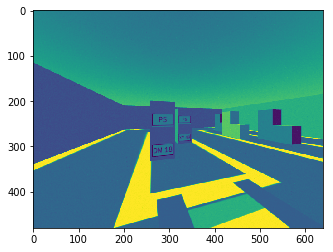

In [63]:
# 1) Convert to greyscale

grey_img_list = []

for test_img in test_img_list:
    grey_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    grey_img_list.append(grey_img)

    plt.imshow(grey_img)
    plt.show()


from image 0


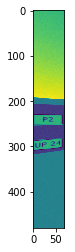

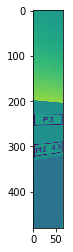

from image 1


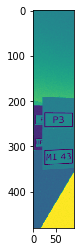

from image 2


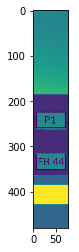

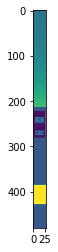

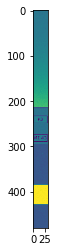

from image 3


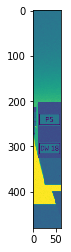

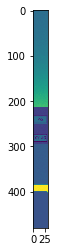

from image 4


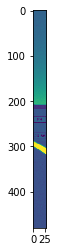

from image 5


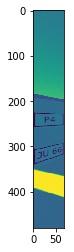

from image 6


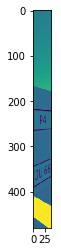

from image 7


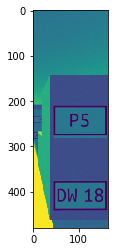

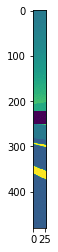

from image 8


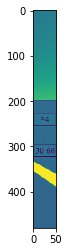

from image 9


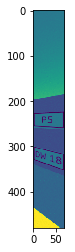

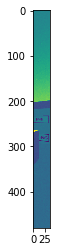

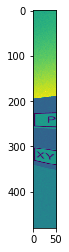

from image 10


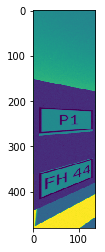

from image 11


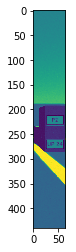

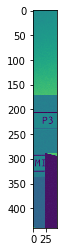

from image 12
from image 13


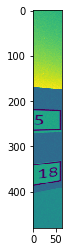

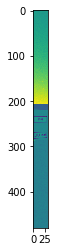

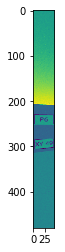

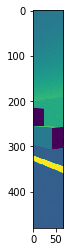

from image 14


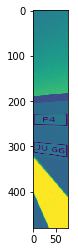

from image 15


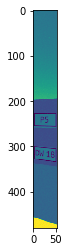

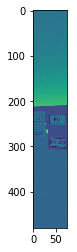

from image 16


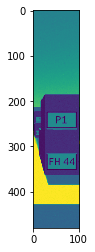

from image 17


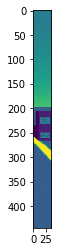

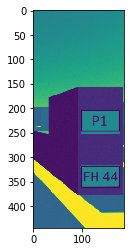

from image 18


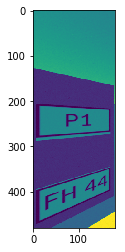

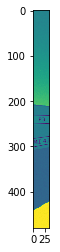

from image 19


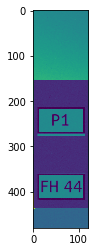

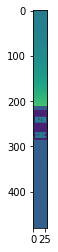

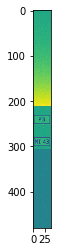

from image 20


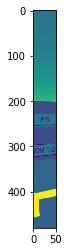

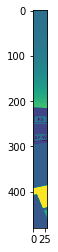

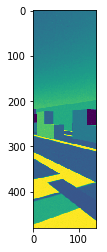

In [116]:
# split into strips vertically
chunks = split_images(grey_img_list, horizontal=False, min_len=25)

# 1D list of all vertical strips
new_images = []

for i in range(len(chunks)):
    print("from image {}".format(i))
    for chunk in chunks[i]:
        new_images.append(grey_img_list[i][:, chunk[0]:chunk[1]])
        plt.imshow(grey_img_list[i][:, chunk[0]:chunk[1]])
        plt.show()

i = 0


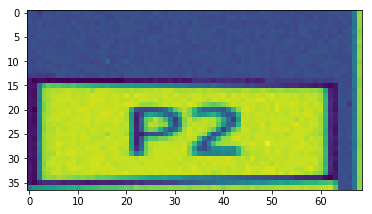

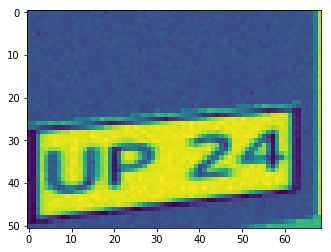

i = 1


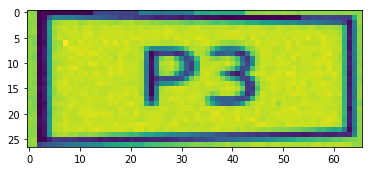

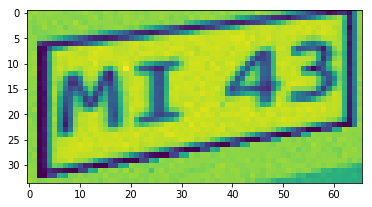

i = 2


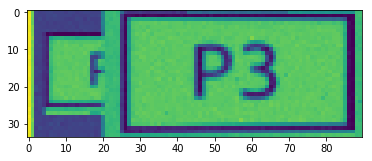

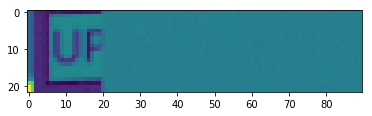

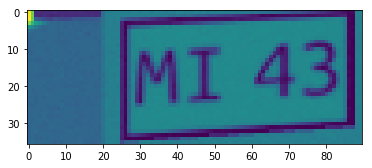

i = 3


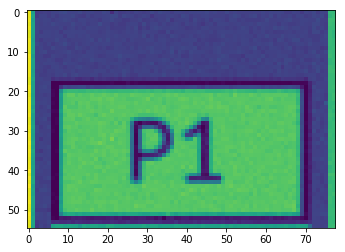

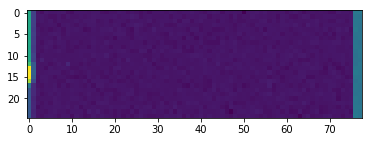

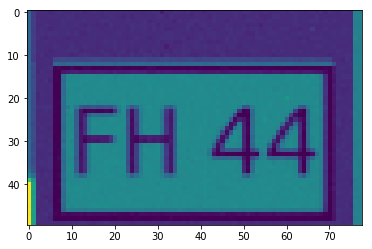

i = 4


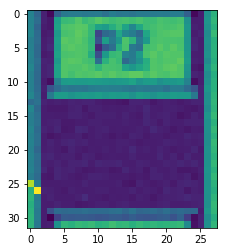

i = 5
i = 6


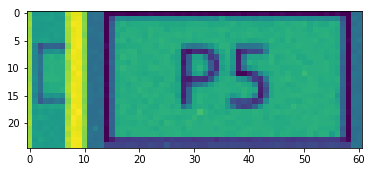

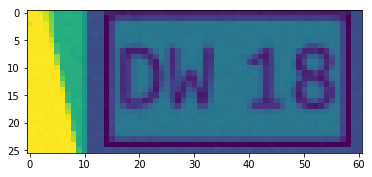

i = 7


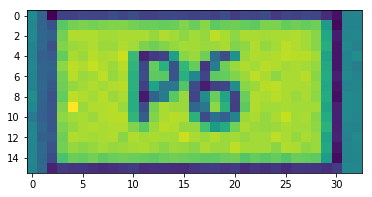

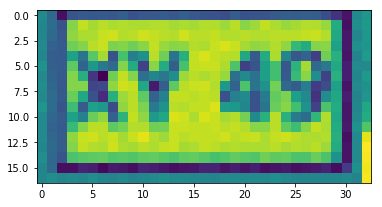

i = 8
i = 9


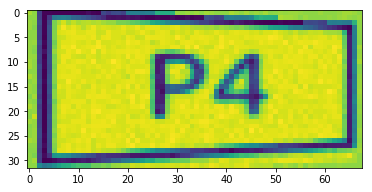

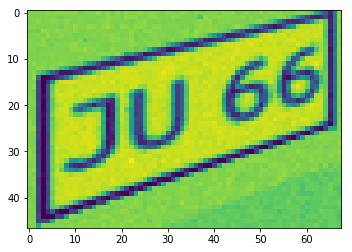

i = 10


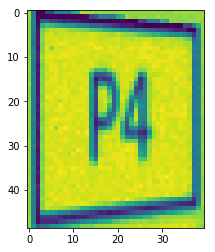

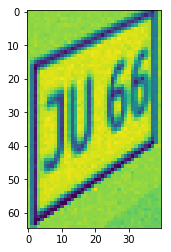

i = 11


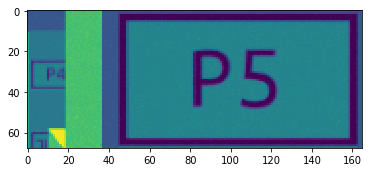

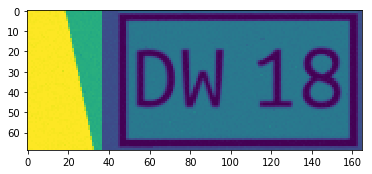

i = 12


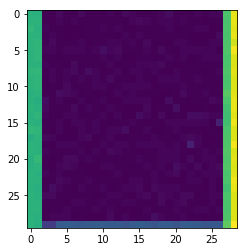

i = 13


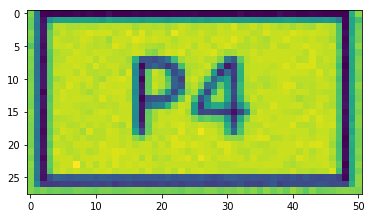

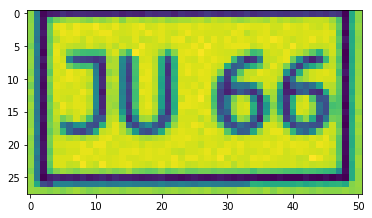

i = 14


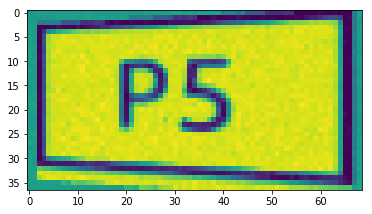

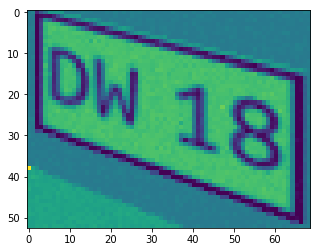

i = 15


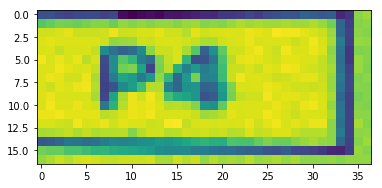

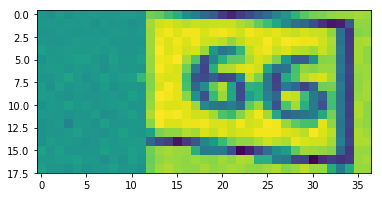

i = 16


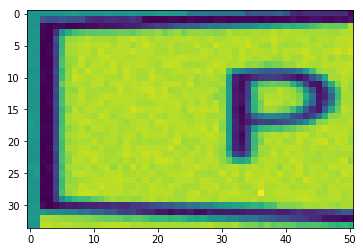

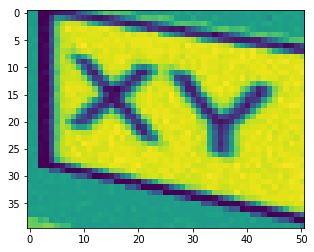

i = 17


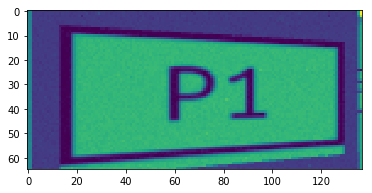

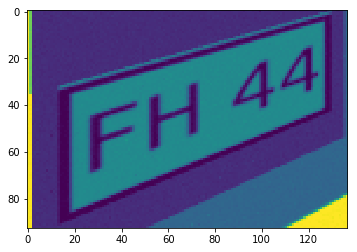

i = 18


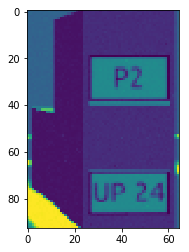

i = 19


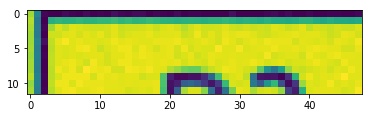

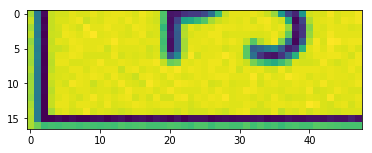

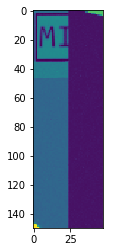

i = 20


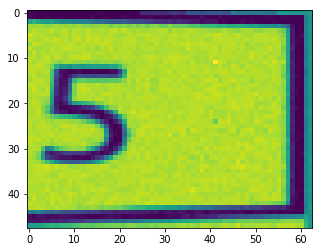

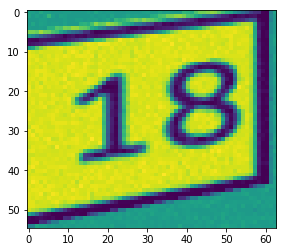

i = 21


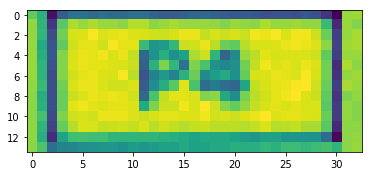

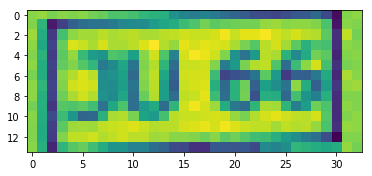

i = 22


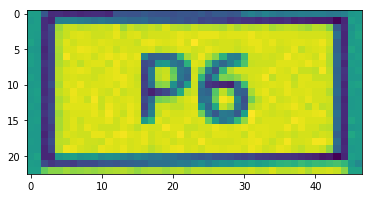

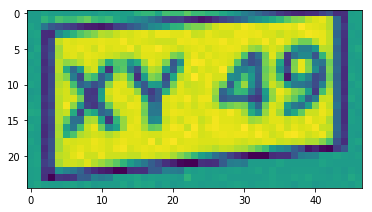

i = 23


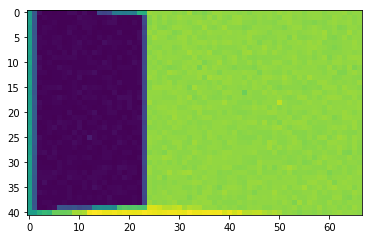

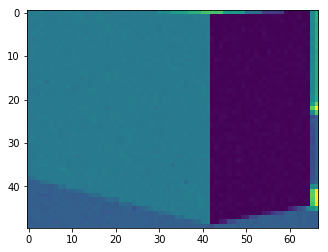

i = 24


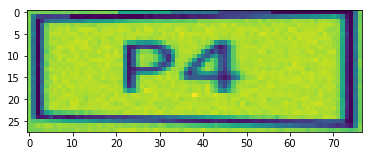

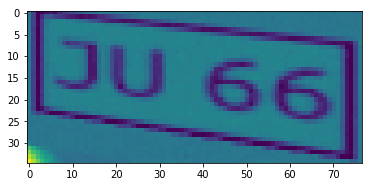

i = 25


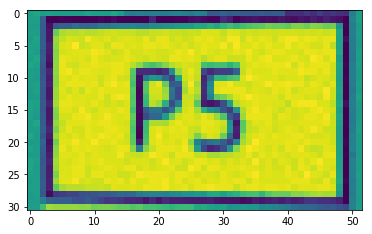

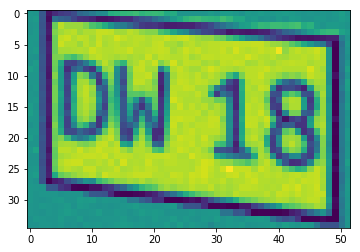

i = 26


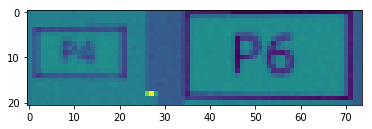

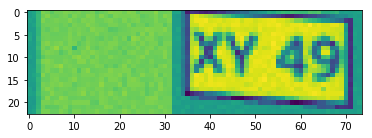

i = 27


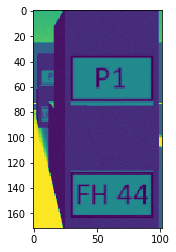

i = 28


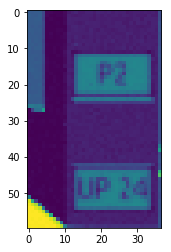

i = 29


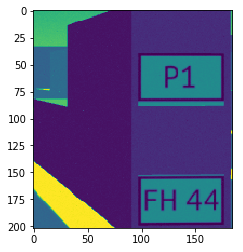

i = 30


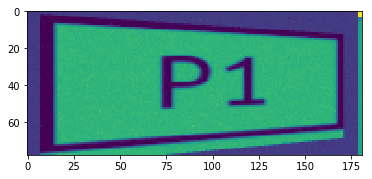

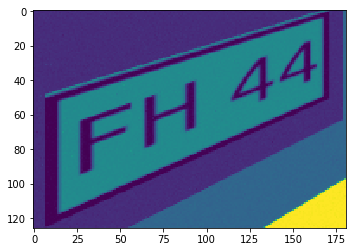

i = 31


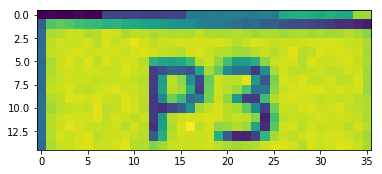

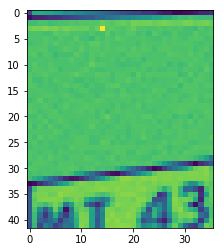

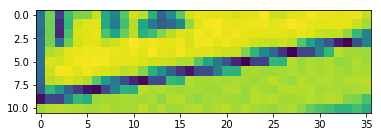

i = 32


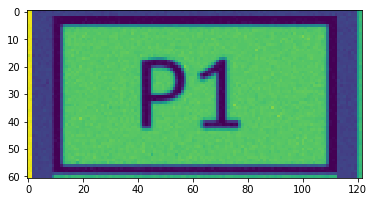

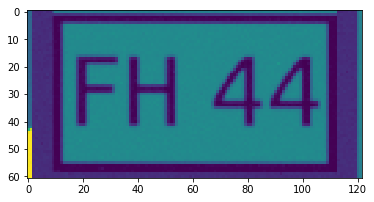

i = 33


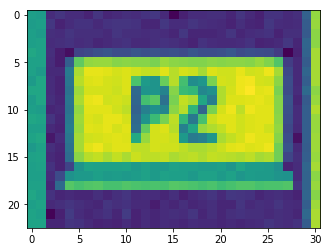

i = 34


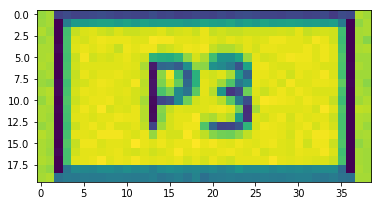

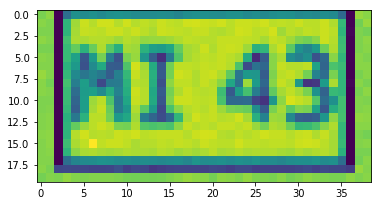

i = 35


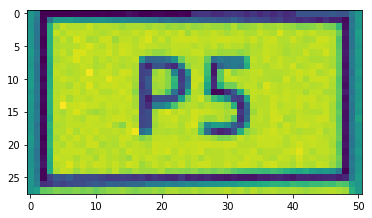

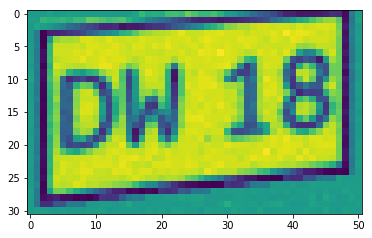

i = 36


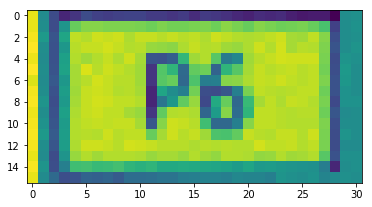

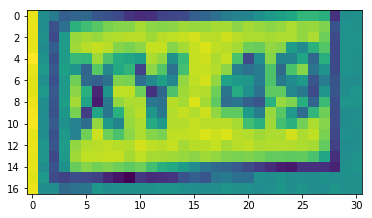

i = 37


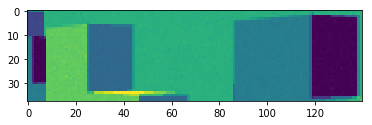

In [118]:
# now split each chunk horizontally
    
chunks_2 = split_images(new_images, horizontal=True, t_mod=5, min_len=10)

# a 2D list: a list of pairs of plates (each vertical strip should be two plates)
plate_pairs = []

for i in range(len(chunks_2)):
    print("i = {}".format(i))
    plate_pairs.append([])
    for chunk in chunks_2[i]:
        plate_pairs[i].append(new_images[i][chunk[0]:chunk[1], :])
        plt.imshow(new_images[i][chunk[0]:chunk[1], :])
        plt.show()
    

before splitting
after splitting


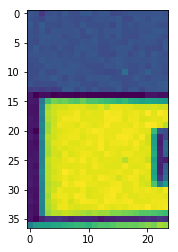

after splitting


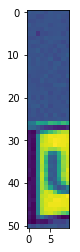

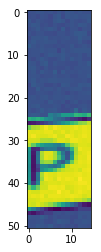

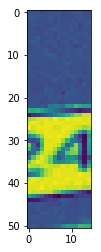

before splitting
after splitting


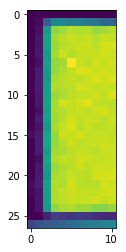

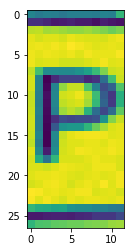

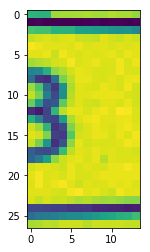

after splitting


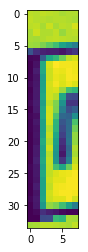

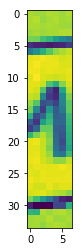

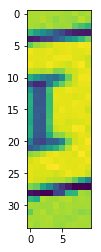

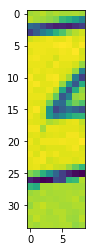

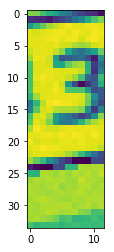

before splitting
after splitting


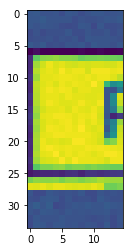

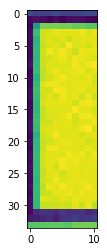

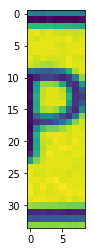

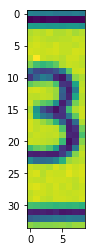

after splitting


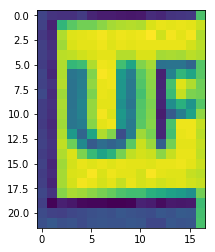

after splitting


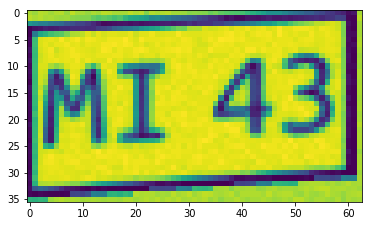

before splitting
after splitting


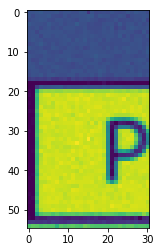

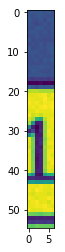

after splitting
after splitting


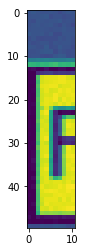

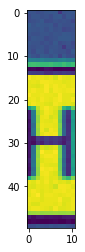

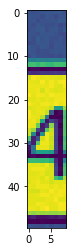

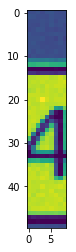

before splitting
after splitting
before splitting
before splitting
after splitting


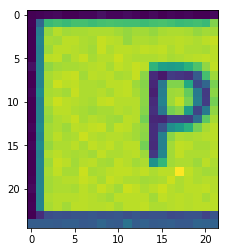

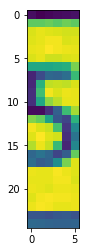

after splitting


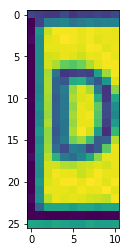

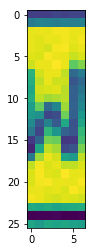

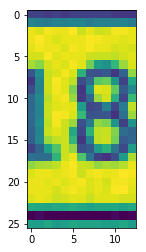

before splitting
after splitting


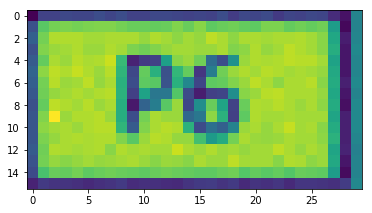

after splitting


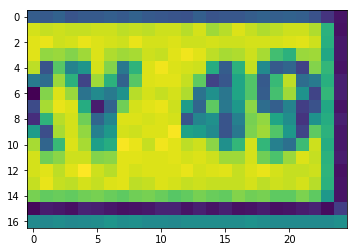

before splitting
before splitting
after splitting


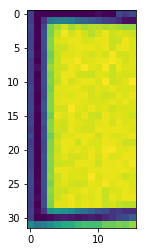

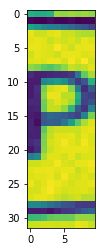

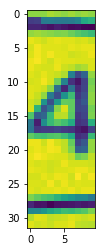

after splitting


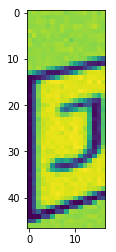

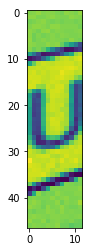

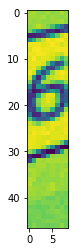

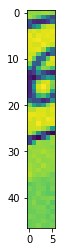

before splitting
after splitting


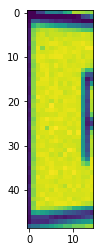

after splitting


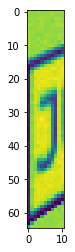

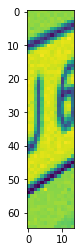

before splitting
after splitting


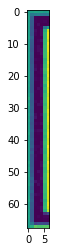

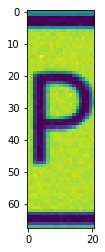

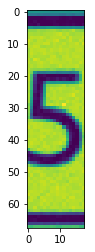

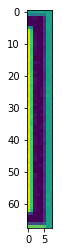

after splitting


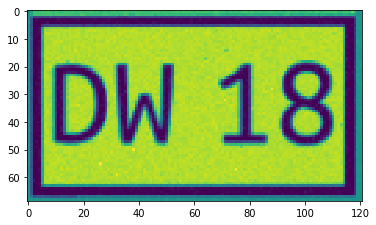

before splitting
after splitting
before splitting
after splitting


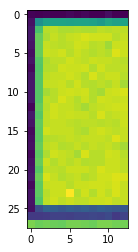

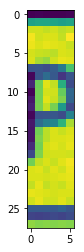

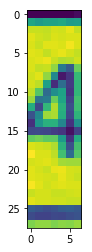

after splitting


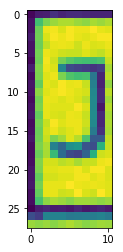

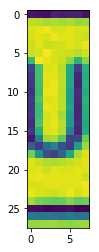

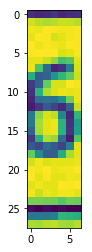

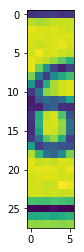

before splitting
Multiple modes
Multiple modes
after splitting


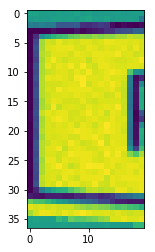

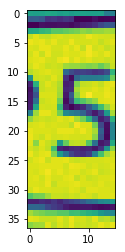

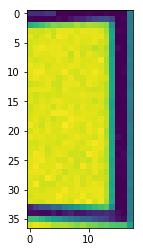

after splitting


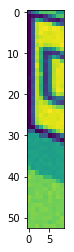

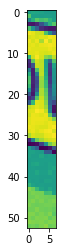

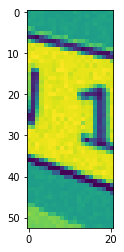

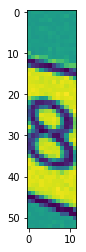

before splitting
after splitting


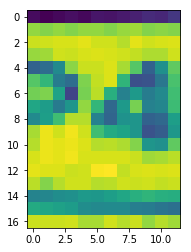

after splitting


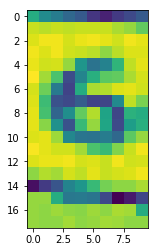

before splitting
Multiple modes
Multiple modes
Multiple modes
Multiple modes
after splitting


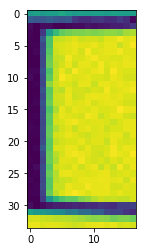

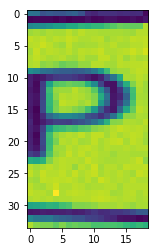

after splitting


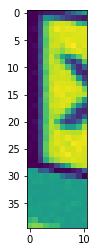

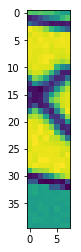

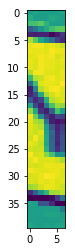

before splitting
after splitting


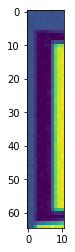

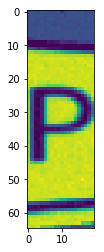

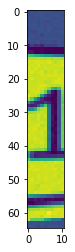

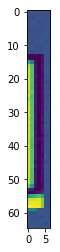

after splitting


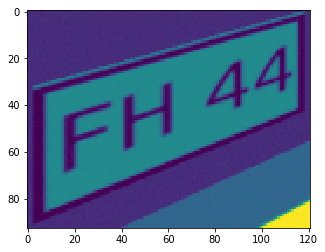

before splitting
after splitting


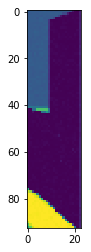

before splitting
after splitting


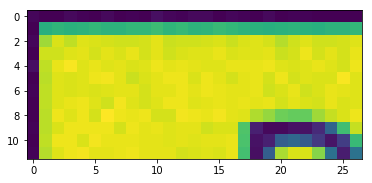

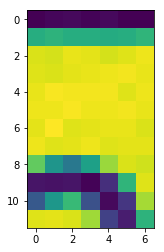

after splitting


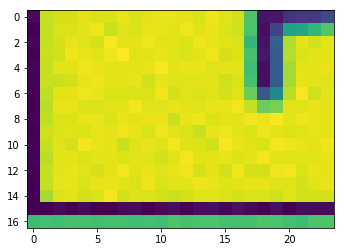

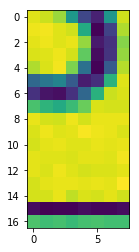

after splitting


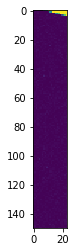

before splitting
after splitting


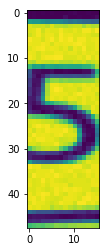

after splitting


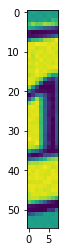

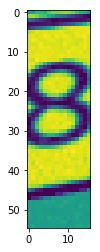

before splitting
after splitting


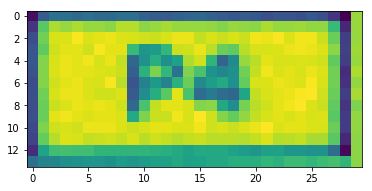

after splitting
before splitting
after splitting


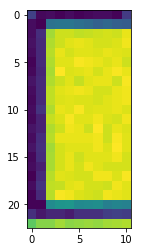

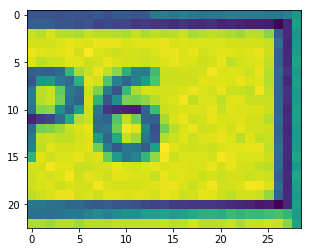

after splitting


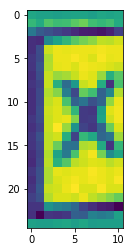

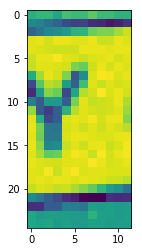

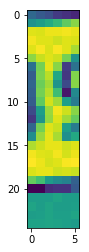

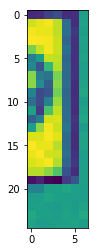

before splitting
after splitting


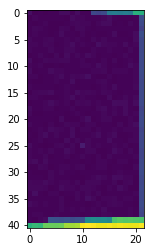

after splitting


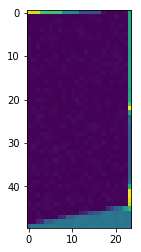

before splitting
after splitting


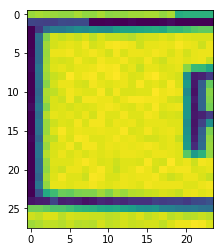

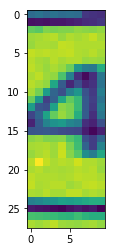

after splitting


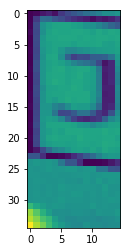

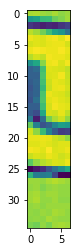

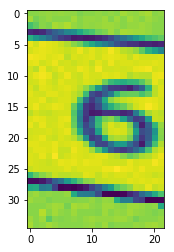

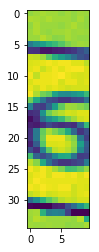

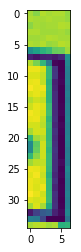

before splitting
after splitting


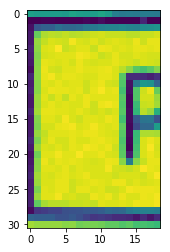

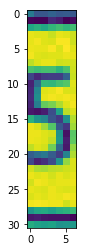

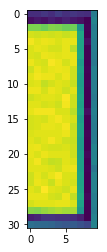

after splitting


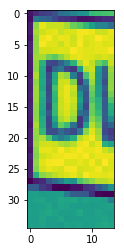

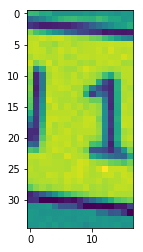

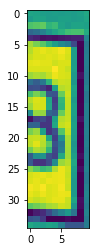

before splitting
after splitting


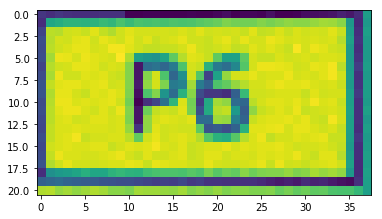

after splitting


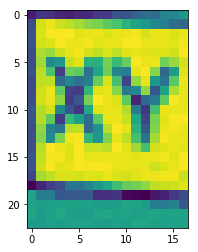

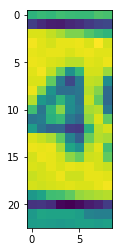

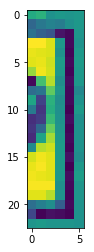

before splitting
after splitting


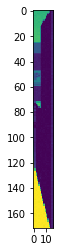

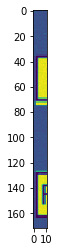

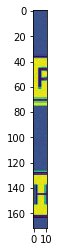

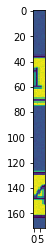

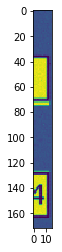

before splitting
after splitting


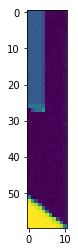

before splitting
after splitting


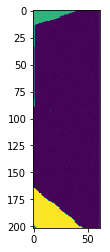

before splitting
after splitting


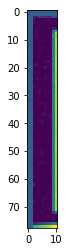

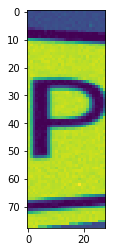

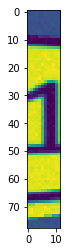

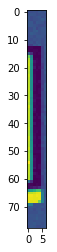

after splitting


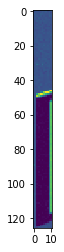

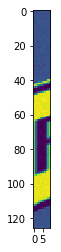

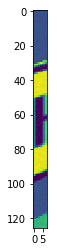

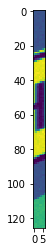

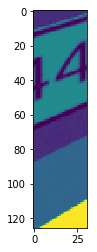

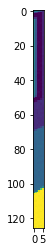

before splitting
after splitting


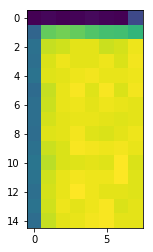

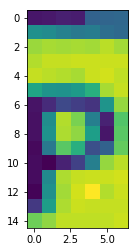

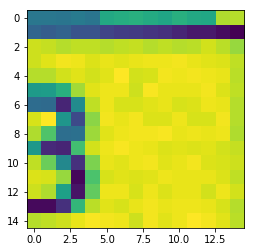

after splitting


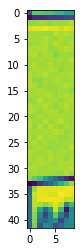

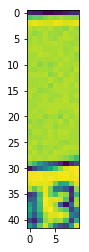

after splitting


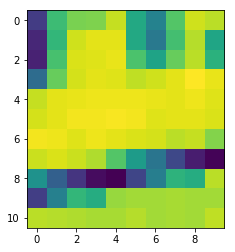

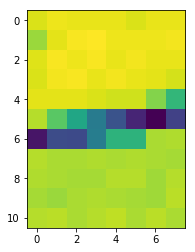

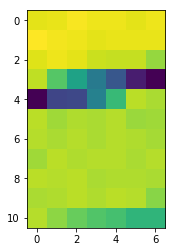

before splitting
Multiple modes
Multiple modes
Multiple modes
after splitting


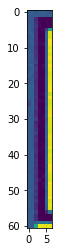

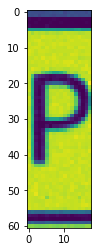

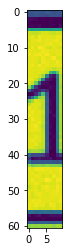

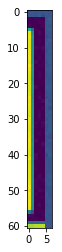

after splitting


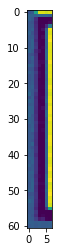

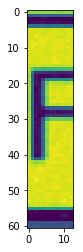

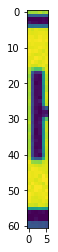

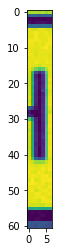

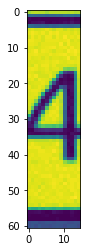

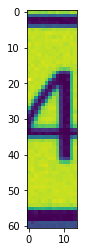

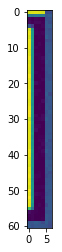

before splitting
after splitting
before splitting
after splitting


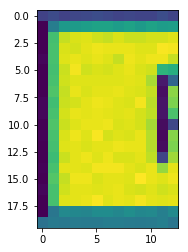

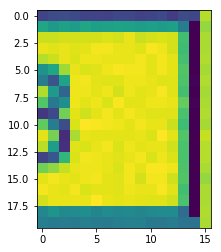

after splitting


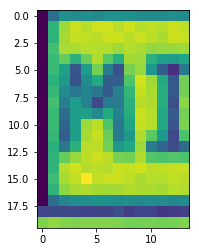

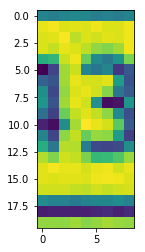

before splitting
Multiple modes
Multiple modes
Multiple modes
after splitting


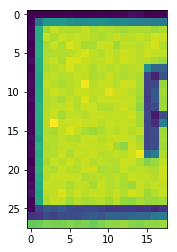

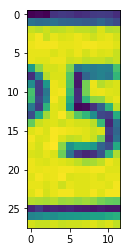

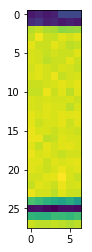

after splitting


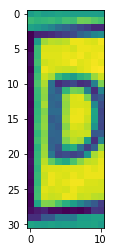

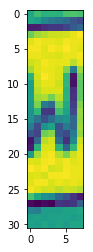

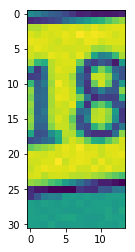

before splitting
after splitting


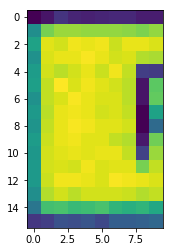

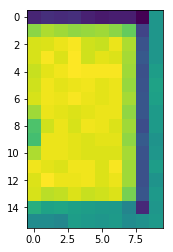

after splitting


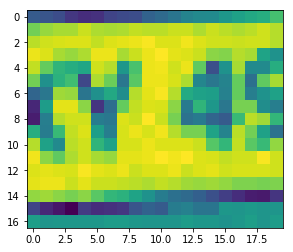

before splitting
after splitting


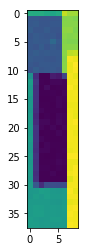

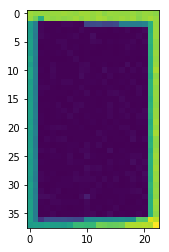

In [119]:
# now take each pair of license plates and vertically split them again

# each split_plates[i] should contain two lists, one of the parking spot (size 2) and one of the plate (size 4)
split_plates = []

for i in range(len(plate_pairs)):
    split_plates.append([])
    print("before splitting")
        
    chunks_3 = split_images(plate_pairs[i], horizontal=False, t_mod=4, avg_mod=3)
    
    for j in range(len(chunks_3)):
        print("after splitting")
        
        split_plates[i].append([])
        
        for chunk in chunks_3[j]:
            split_plates[i][j].append(plate_pairs[i][j][:, chunk[0]:chunk[1]])
            plt.imshow(plate_pairs[i][j][:, chunk[0]:chunk[1]])
            plt.show()
        